In [1]:
import msprime
import allel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nbSamples = 10
pops = ['pop1', 'pop2', 'pop3']
nbPops = 3

population_configurations=[
    msprime.PopulationConfiguration(sample_size = 2*nbSamples),
    msprime.PopulationConfiguration(sample_size = 2*nbSamples),
    msprime.PopulationConfiguration(sample_size = 2*nbSamples)]

m = 3 / (4 * 15000)

migration_matrix=[
        [0, m, 0],
        [m, 0, m],
        [0, m, 0]]

In [3]:
def segregating_sites_examples(num_replicates, nbSamples, nbPops, migration_matrix, population_confiurations):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(Ne=15000, length= 50,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates,
                                  migration_matrix = migration_matrix, 
                                  population_configurations = population_configurations)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbPops*nbSamples,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [4]:
g = allel.model.GenotypeArray(segregating_sites_examples(3000, nbSamples, nbPops, migration_matrix, population_configurations))
g

<GenotypeArray shape=(1422, 30, 2) dtype=int8>
1/0 1/1 0/1 1/1 1/1 ... 0/0 0/0 0/0 1/0 1/1
1/0 1/0 1/1 0/1 1/0 ... 1/1 0/1 1/1 1/1 1/1
0/0 1/0 0/1 0/0 0/0 ... 1/0 0/0 1/0 0/1 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
1/0 0/0 0/0 0/0 1/0 ... 0/1 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 1/0 ... 0/0 1/0 1/1 1/1 1/0

## Shrinkage correction (Lee et al., 2010)

In [5]:
def inverse_rho(d, gamma):
    return((d + 1 - gamma + np.sqrt((d + 1 - gamma)**2 - 4*d)) / 2)

def step2(d_v, gamma, corrected_eigenval, p, r_v):
    for i in np.arange(len(d_v)):
        nb = d_v[i]
        if(nb > (1 + np.sqrt(gamma))**2):
            corrected_eigenval[i] = inverse_rho(nb, gamma)
        else:
            corrected_eigenval[i] = 1
    k_i = sum(corrected_eigenval > 1)
    S = sum(corrected_eigenval[:k_i])
    d_v = (S + p - k_i) * r_v
    t2 = S + p - k_i
    return{'d_v': d_v, 'corrected_eigenval': corrected_eigenval, 't2': t2, 'k_i': k_i}

def shrinkage_correction_lee(m, n, p, eigenval, scores):
    """
    Algorithm of shrinkage correction for PCA projection, detailed in Lee et al., 2010.
        ** INPUT **
        - m: number of effective principal components
        - n: number of samples used to perform the 1st PCA (i.e. without the sample to project)
        - p: number of SNPs
        - eigenval: list of the sample eigenvalues that should be rescaled, i.e. computed without sample(s) to project
        - scores: PC scores corresponding to the eigenvalues, computed for projected sample(s). These are the scores
                  to rescale.
        
        ** OUTPUT **
        - result: matrix of corrected scores for the projected sample(s).
    """
    sum_eigenval = sum(eigenval)
    r_v = eigenval / sum_eigenval
    gamma = p / n
    corrected_eigenval = np.zeros(len(eigenval))
    t = 0
    
    # Step 1: Initialization of the rescaled eigenvalues
    d_v = r_v * p 
    
    # Step 2:
    result = step2(d_v, gamma, corrected_eigenval, p, r_v)
    t2 = result['t2']
    d_v = result['d_v']
    corrected_eigenval = result['corrected_eigenval']
    
    # Step 3:
    j = 1000
    while j > 0:
        t = t2
        result2 = step2(d_v, gamma, corrected_eigenval, p, r_v)
        t2 = result2['t2']
        d_v = result2['d_v']
        corrected_eigenval = result2['corrected_eigenval']
        j -= 1
    result = scores[:, 0:m] * ((inverse_rho(d_v[0:m], gamma) + gamma - 1) / (inverse_rho(d_v[0:m], gamma) - 1))

    return(result)

In [6]:
from sklearn.decomposition import PCA

Text(0.5,1,'PCA run on all samples')

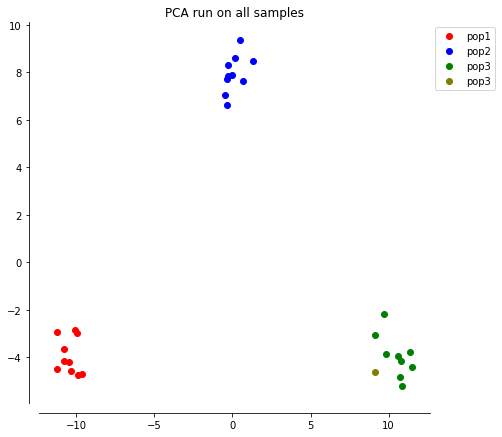

In [7]:
# PCA run on all samples
gn = g.to_n_alt()[:]

pca = PCA(n_components = 30)
pca.fit(gn.T)
X = pca.transform(gn.T)
fig, ax = plt.subplots(figsize=(7,7))
sns.despine(ax=ax, offset=10)
ax.plot(X[0:10,0], X[0:10,1], marker='o', linestyle=' ', label='pop1', color='red')
ax.plot(X[10:20,0], X[10:20,1], marker='o', linestyle=' ', label='pop2', color="blue")
ax.plot(X[20:29,0], X[20:29,1], marker='o', linestyle=' ', label='pop3', color='green')
ax.plot(X[29:30,0], X[29:30,1], marker='o', linestyle=' ', label='pop3', color='olive')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title("PCA run on all samples")

Text(0.5,1,'Lee, 2010')

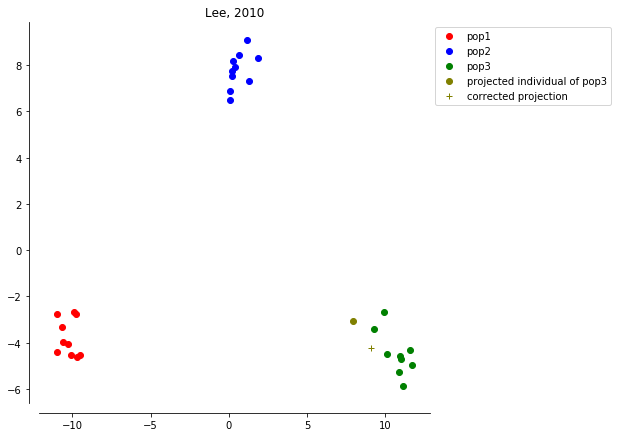

In [8]:
# Lee's correction
p = g.shape[0] # number of SNPs
n = g.shape[1]-1 # number of samples
gn = g.to_n_alt()[:]

pca = PCA(n_components = 29)
pca.fit(gn[:,0:29].T)
X = pca.transform(gn[:,0:29].T)
eigenval = pca.singular_values_ ** 2 / n
comp = pca.components_
Y_old = np.dot(gn[:,29:30].T, comp.T)

new_scores = shrinkage_correction_lee(3, n, p, eigenval, Y_old)
# plt.plot(new_scores)

fig, ax = plt.subplots(figsize=(7,7))
sns.despine(ax=ax, offset=10)
ax.plot(X[0:10,0], X[0:10,1], marker='o', linestyle=' ', label='pop1', color='red')
ax.plot(X[10:20,0], X[10:20,1], marker='o', linestyle=' ', label='pop2', color="blue")
ax.plot(X[20:29,0], X[20:29,1], marker='o', linestyle=' ', label='pop3', color='green')
ax.plot(Y_old[:,0], Y_old[:,1], marker='o', linestyle=' ', label='projected individual of pop3', color='olive')
ax.plot(new_scores[:,0], new_scores[:,1], marker='+', linestyle=' ', label='corrected projection', color='olive')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title("Lee, 2010")

## Shrinkage correction, Jung 2017

Text(0.5,1,'Jung, 2017')

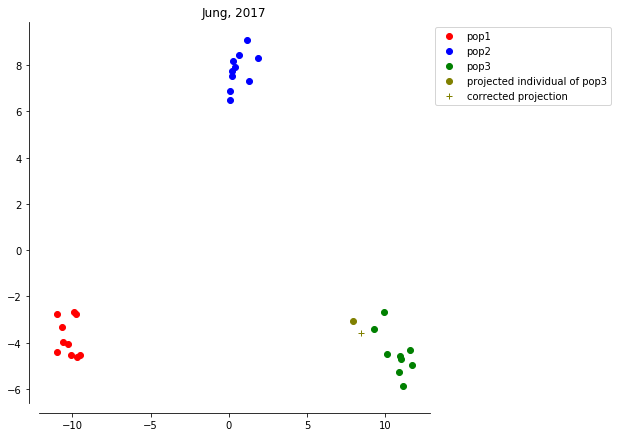

In [9]:
# Jung, 2017

def shrinkage_correction_jung(m, n, d, eigenval):
    """
    Algorithm of shrinkage correction for PCA projection, detailed in Lee et al., 2010.
        ** INPUT **
        - m: number of effective principal components
        - n: number of samples used to perform the 1st PCA (i.e. without the sample to project)
        - p: number of SNPs
        - eigenval: list of the sample eigenvalues that should be rescaled, i.e. computed without sample(s) to project

        ** OUTPUT **
        - est_rho: estimators of shrinkage coefficients. New scores are obtained by multiplying est_rho with scores
                   of the projected sample(s)
    """
    est_tau = (sum(eigenval[m+1:]) / (n-m)) * (n/d)
    est_lambda = (n/d) * eigenval[:m] - est_tau
    est_rho = np.sqrt(1 + (est_tau/est_lambda[0:m]))
    
    return(est_rho)
    

d = g.shape[0] # number of SNPs
n = g.shape[1]-1 # number of samples
gn = g.to_n_alt()[:]

pca = PCA(n_components = 29)
pca.fit(gn[:,0:29].T)
X = pca.transform(gn[:,0:29].T)
eigenval = pca.singular_values_ ** 2 / n
m = 3
comp = pca.components_

est_rho = shrinkage_correction_jung(m, n, p, eigenval)

Y_old = np.dot(gn[:,29:30].T, comp.T)
new_scores = est_rho * Y_old[:,0:m]


fig, ax = plt.subplots(figsize=(7,7))
sns.despine(ax=ax, offset=10)
ax.plot(X[0:10,0], X[0:10,1], marker='o', linestyle=' ', label='pop1', color='red')
ax.plot(X[10:20,0], X[10:20,1], marker='o', linestyle=' ', label='pop2', color="blue")
ax.plot(X[20:29,0], X[20:29,1], marker='o', linestyle=' ', label='pop3', color='green')
ax.plot(Y_old[:,0], Y_old[:,1], marker='o', linestyle=' ', label='projected individual of pop3', color='olive')
ax.plot(new_scores[:,0], new_scores[:,1], marker='+', linestyle=' ', label='corrected projection', color='olive')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title("Jung, 2017")

## Shrinkage correction, Dey 2016 

Text(0.5,1,'Dey and Lee, 2016')

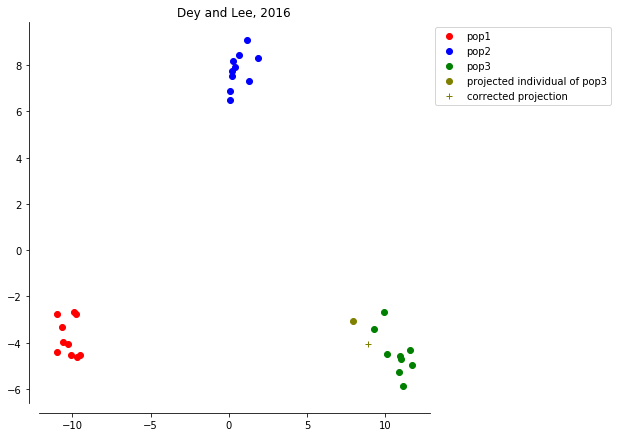

In [10]:
def shrinkage_correction_dey(samp_eval, n_spikes, p, n):
    """
    Algorithm of shrinkage correction for PCA projection, detailed in Dey, 2016.
        ** INPUT **
        - samp_eval: list of the sample eigenvalues that should be rescaled, i.e. computed without sample(s) to project.
        - n_spikes: number of effective principal components
        - p: number of SNPs
        - n: number of samples used to perform the 1st PCA (i.e. without the sample to project)

        ** OUTPUT **
        - shrinkage: estimators of shrinkage coefficients. New scores are obtained by dividing scores of the projected 
                     sample(s) by these coefficients.
    """
    gamma = p/n
    spike_est = np.zeros(n_spikes)
    for i in np.arange(n_spikes):
        temp = 0
        for j in np.arange((n_spikes+1), len(samp_eval)):
            temp = temp + samp_eval[j] / (samp_eval[i]-samp_eval[j])
        spike_est[i] = samp_eval[i] / (1+(gamma/(p-n_spikes))*temp)
        
    shrinkage = spike_est / samp_eval[0:n_spikes]
    return(shrinkage)


d = g.shape[0] # number of SNPs
n = g.shape[1] # number of samples
gn = g.to_n_alt()[:]

pca = PCA(n_components = 29)
pca.fit(gn[:,0:29].T)
X = pca.transform(gn[:,0:29].T)
eigenval = pca.singular_values_ ** 2 / n
m = 3
comp = pca.components_
Y_old = np.dot(gn[:,29:30].T, comp.T)

shrinkage = shrinkage_correction_dey(eigenval, m, p, n)
new_scores = Y_old[:, 0:m] / shrinkage

fig, ax = plt.subplots(figsize=(7,7))
sns.despine(ax=ax, offset=10)
ax.plot(X[0:10,0], X[0:10,1], marker='o', linestyle=' ', label='pop1', color='red')
ax.plot(X[10:20,0], X[10:20,1], marker='o', linestyle=' ', label='pop2', color="blue")
ax.plot(X[20:29,0], X[20:29,1], marker='o', linestyle=' ', label='pop3', color='green')
ax.plot(Y_old[:,0], Y_old[:,1], marker='o', linestyle=' ', label='projected individual of pop3', color='olive')
ax.plot(new_scores[:,0], new_scores[:,1], marker='+', linestyle=' ', label='corrected projection', color='olive')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title("Dey and Lee, 2016")

### PCA run on samples of 2 populations, and projection of the third population

In [11]:
gn = g.to_n_alt()[:]
coords, model = allel.stats.pca(gn[:,0:20], scaler=None)
coords.shape

(20, 10)

In [12]:
coords_3 = model.transform(gn[:,20:30])

In [13]:
colors = {
    'pop1': 'blue',
    'pop2': 'red',
    'pop3': 'green'
}

Text(0.5,1,'pop3 projected onto PCA')

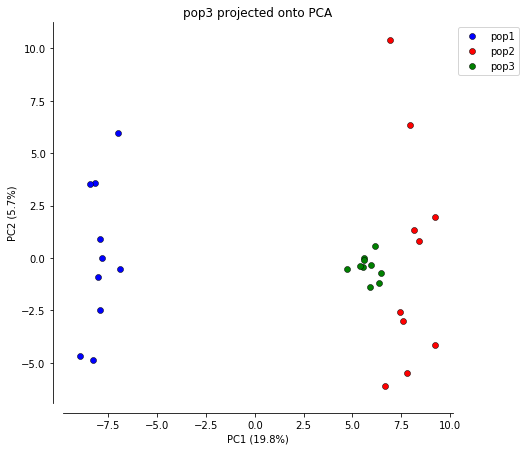

In [14]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    i = 0
    for pop in pops[0:2]:
        x = coords[i:i+nbSamples, pc1]
        y = coords[i:i+nbSamples, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=pop, color=colors[pop], markersize=6, mec='k', mew=.5)
        i += nbSamples
    x = coords_3[0:nbSamples, pc1]
    y = coords_3[0:nbSamples, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label='pop3', color=colors['pop3'], markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
    
fig, ax = plt.subplots(figsize=(7,7))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title('pop3 projected onto PCA')

### PCA run on all samples

In [15]:
coords, model = allel.stats.pca(gn, scaler=None)
coords.shape

(30, 10)

Text(0.5,1,'PCA run on all samples')

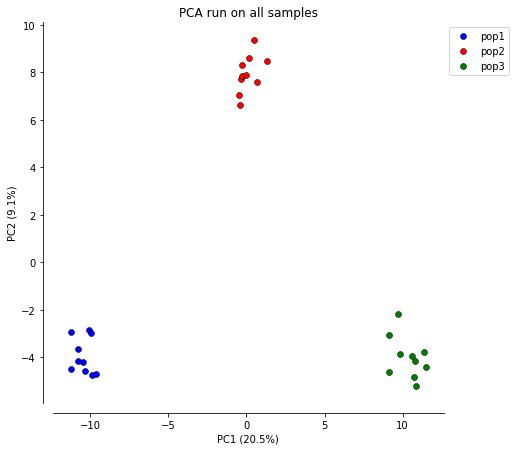

In [16]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    i = 0
    for pop in pops:
        x = coords[i:i+nbSamples, pc1]
        y = coords[i:i+nbSamples, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=pop, color=colors[pop], markersize=6, mec='k', mew=.5)
        i += nbSamples
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
    
fig, ax = plt.subplots(figsize=(7,7))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title('PCA run on all samples')

Projection vs No projection:<br>
PCA run on samples of pop1 and pop2, pop3 projected -> shrinkage of pop3 toward (0,0) 

# Shrinkage of ancient samples

In [17]:
nbM = 20
nbA = 2
age = 1000
samples = [msprime.Sample(0,0) for i in np.arange(2*nbM)] + [msprime.Sample(0,age) for i in np.arange(2*nbA)]

In [18]:
def run_sim(num_replicates, nbA, nbM, samples):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(Ne=15000, length= 2e2, samples = samples,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbM+nbA,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [19]:
g = allel.model.GenotypeArray(run_sim(8000, nbA, nbM, samples))
g

<GenotypeArray shape=(4275, 22, 2) dtype=int8>
0/1 1/0 0/0 0/0 0/1 ... 0/0 0/0 1/1 0/0 0/0
0/1 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 1/0 0/0 1/0 ... 0/0 1/0 0/0 0/1 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 1/0 0/0
0/0 0/0 0/0 0/0 1/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/1 1/0 0/0 0/0 0/1

### PCA run on all samples

In [20]:
gn = g.to_n_alt()[:]
coords, model = allel.stats.pca(gn, scaler=None)
coords.shape

(22, 10)

In [21]:
colors = {
    'modern': 'blue',
    'ancient': 'red'
}

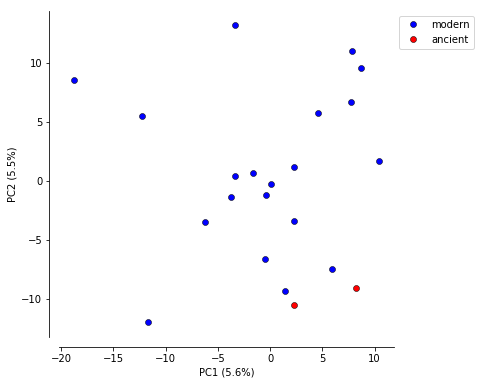

In [22]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    i = 0
    # modern samples
    x = coords[0:nbM, pc1]
    y = coords[0:nbM, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=colors['modern'], markersize=6, mec='k', mew=.5)
    i += nbM
    # ancient samples
    x = coords[i:i+nbA, pc1]
    y = coords[i:i+nbA, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label='ancient',
            color=colors['ancient'], markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

### Ancient samples projected onto PCA run on modern samples

In [23]:
coords, model = allel.stats.pca(gn[:,0:20], scaler=None)
ancient_gn = gn[:,20:22]
coords2 = model.transform(ancient_gn)

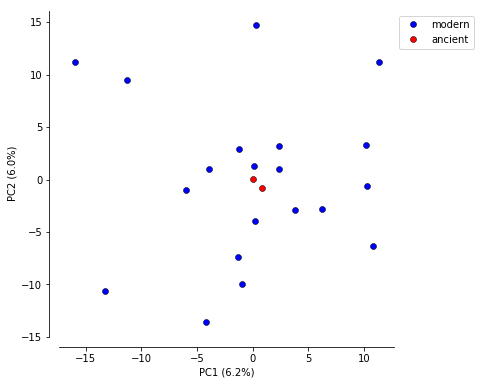

In [24]:
def plot_pca_coords(coords, coords2, model, pc1, pc2, ax):
    i = 0
    # modern samples
    x = coords[0:nbM, pc1]
    y = coords[0:nbM, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=colors['modern'], markersize=6, mec='k', mew=.5)
    i += nbM
    # ancient samples
    x = coords2[0:nbA, pc1]
    y = coords2[0:nbA, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label='ancient',
            color=colors['ancient'], markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, coords2, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

In [25]:
p = g.shape[0] # number of SNPs
n = g.shape[1] # number of samples
gn = g.to_n_alt()[:]

pca = PCA(n_components = 30)
pca.fit(gn[:,0:20].T)
X = pca.transform(gn[:,0:20].T)
eigenval = pca.singular_values_ ** 2 / n
comp = pca.components_
Y_old = np.dot(gn[:,20:22].T, comp.T)

new_scores = shrinkage_correction(n, p, eigenval, comp)
# plt.plot(new_scores)

Y = np.dot(gn[:,20:22].T, new_scores.T)
plt.plot(X[:,0], X[:,1], 'bo', Y_old[:,0], Y_old[:,1], 'go', Y[:,0], Y[:,1], 'r+')

NameError: name 'shrinkage_correction' is not defined

Projected ancient samples are shrunk towards (0,0)

# Ancient samples from several times

In [ ]:
nbM = 20
nbA = 2
ages = [500,1000,1500]
samples = [msprime.Sample(0,0) for i in np.arange(2*nbM)]
for a in ages:
    samples += [msprime.Sample(0,a) for i in np.arange(2*nbA)]

In [ ]:
def run_sim(num_replicates, nbA, nbM, ages, samples):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(Ne=15000, length= 2e2, samples = samples,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbM+nbA*len(ages),2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [ ]:
g = allel.model.GenotypeArray(run_sim(15000, nbA, nbM, ages, samples))
g

### PCA run on all samples

In [ ]:
gn = g.to_n_alt()[:]
coords, model = allel.stats.pca(gn, scaler=None)
coords.shape

In [ ]:
colors = {
    'modern': 'blue',
    500: 'red',
    1000: 'orange',
    1500: 'yellow'
}

In [ ]:
def plot_pca_coords(coords, model, pc1, pc2, ax, ages):
    i = 0
    # modern samples
    x = coords[0:nbM, pc1]
    y = coords[0:nbM, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=colors['modern'], markersize=6, mec='k', mew=.5)
    i += nbM
    # ancient samples
    for a in ages:
        x = coords[i:i+nbA, pc1]
        y = coords[i:i+nbA, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=a,
            color=colors[a], markersize=6, mec='k', mew=.5)
        i += nbA
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax, ages)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

### Projection of ancient samples

In [ ]:
coords, model = allel.stats.pca(gn[:,0:20], scaler=None)
ancient_gn = gn[:,20:25]
coords2 = model.transform(ancient_gn)

In [ ]:
def plot_pca_coords(coords, coords2, model, pc1, pc2, ax, ages):
    i = 0
    # modern samples
    x = coords[0:nbM, pc1]
    y = coords[0:nbM, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=colors['modern'], markersize=6, mec='k', mew=.5)
    i += nbM
    # ancient samples
    j = 0
    for a in ages:
        x = coords2[j:j+nbA, pc1]
        y = coords2[j:j+nbA, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=a,
                color=colors[a], markersize=6, mec='k', mew=.5)
        j += nbA
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, coords2, model, 0, 1, ax, ages)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

# Ancient samples in two populations

In [ ]:
nbM = 20
nbA = 3
age = 1000
nbPops = 3
Ne = 15000
m = 1/(4*Ne)

samples = [msprime.Sample(0,0) for i in np.arange(2*nbM)] + [msprime.Sample(1,0) for i in np.arange(2*nbM)] + [msprime.Sample(2,0) for i in np.arange(2*nbM)]
samples += [msprime.Sample(0,age) for i in np.arange(2*nbA)] + [msprime.Sample(1,age) for i in np.arange(2*nbA)] + [msprime.Sample(2,age) for i in np.arange(2*nbA)]
population_configurations = [msprime.PopulationConfiguration() for i in np.arange(nbPops)]
migration_matrix = [
    [0,m,0],
    [m,0,m],
    [0,m,0]
]

In [ ]:
def run_sim(num_replicates, nbM, nbA, nbPops, migration_matrix, population_confiurations, samples):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(Ne=15000, length= 50,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates,
                                  migration_matrix = migration_matrix, 
                                  population_configurations = population_configurations,
                                  samples = samples)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbPops*(nbM+nbA),2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [ ]:
g = allel.model.GenotypeArray(run_sim(10000, nbM, nbA, nbPops, migration_matrix, population_configurations, samples))
g

### PCA run on all samples

In [ ]:
gn = g.to_n_alt()[:]
coords, model = allel.stats.pca(gn, scaler=None)
coords.shape

In [ ]:
colors = {
    'modern pop1': 'blue',
    'modern pop2': 'red',
    'modern pop3': 'green',
    'ancient pop1': 'gray',
    'ancient pop2': 'orange',
    'ancient pop3': 'yellow'
}

modern = ['modern pop1', 'modern pop2', 'modern pop3']
ancient = ['ancient pop1', 'ancient pop2', 'ancient pop3']

In [ ]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    i = 0
    # modern samples
    for m in modern:
        x = coords[i:i+nbM, pc1]
        y = coords[i:i+nbM, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=m, color=colors[m], markersize=6, mec='k', mew=.5)
        i += nbM
    # ancient samples
    for a in ancient:
        x = coords[i:i+nbA, pc1]
        y = coords[i:i+nbA, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=a,
                color=colors[a], markersize=6, mec='k', mew=.5)
        i += nbA
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

### Projection of ancient samples

In [ ]:
coords, model = allel.stats.pca(gn[:,0:60], scaler=None)
ancient_gn = gn[:,60:69]
coords2 = model.transform(ancient_gn)

In [ ]:
def plot_pca_coords(coords, coords2, model, pc1, pc2, ax):
    i = 0
    # modern samples
    for m in modern:
        x = coords[i:i+nbM, pc1]
        y = coords[i:i+nbM, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=m, color=colors[m], markersize=6, mec='k', mew=.5)
        i += nbM
    # ancient samples
    i = 0
    for a in ancient:
        x = coords2[i:i+nbA, pc1]
        y = coords2[i:i+nbA, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=a,
                color=colors[a], markersize=6, mec='k', mew=.5)
        i += nbA
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, coords2, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

Ancient samples are shrunk towards zero

# Several populations, ancient samples in only one

In [ ]:
def writeMigrationMatrix(n, rate):
    """
    Migrations in a 1-dimensional linear stepping-stone model with IBD.
        n = the number of demes 
        rate = migration rate between 2 demes
    """
    migration_matrix = np.zeros((n, n))
    for i in np.arange(1, n-1):
        migration_matrix[i, i+1] = migration_matrix[i, i-1] = migration_matrix[i+1, i] = migration_matrix[i-1, i] = rate
    migration_matrix[0, 1] = migration_matrix[1, 0] = migration_matrix[n-1, n-2] = migration_matrix[n-2, n-1] = rate
    
    return(migration_matrix)

def writePopulationConfigurations(nDemes, sampleSize):
    """
    When several populations or demes have to be simulated, msprime requires the 'population_configurations' parameter.
    This arameter is a list of 'PopulationConfiguration' methods, one call to this method per population or deme.
        nDemes = number of demes or populations to simulate
        sampleSize = number of individuals to sample in each deme/population (to simulate 1 diploid individual,
            sampleSize must be 2)
    """
    population_configurations = []
    for i in range(0, nDemes):
        population_configurations.append(msprime.PopulationConfiguration(sample_size=2*sampleSize))
    return(population_configurations)

In [ ]:
Ne = 15000
M = 0.1
# m = M/(4*Ne)
m = 0.001

nbDemes = 20

population_configurations = [msprime.PopulationConfiguration() for i in np.arange(nbDemes)]
migration_matrix = writeMigrationMatrix(nbDemes, m)
samples = []
for i in np.arange(nbDemes):
    samples.append(msprime.Sample(i,0))
    samples.append(msprime.Sample(i,0))
samples.append(msprime.Sample(5, 4000))
samples.append(msprime.Sample(5, 4000))

In [ ]:
def ibd_1d(num_replicates, population_configurations, migration_matrix, samples, nbDemes):
    s = 0
    replicates = msprime.simulate(Ne = 15000,
                                  samples = samples,
                                  population_configurations = population_configurations,
                                  migration_matrix = migration_matrix,
                                  length = 20, 
                                  recombination_rate = 1e-8,
                                  mutation_rate = 1e-8,
                                  num_replicates = num_replicates
                                 )
    for j, ts in enumerate(replicates): 
        # For each replicate, create a dimensions 3 array of size (number of SNPs, number of diploid samples, 2). This 
        # array will contain the haplotypes for the SNPs of the replicate.
        # Number of diploid samples = number of samples in the replicate / 2 since msprime simulates haploids.
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            # For each SNP, the genotypes (1-dimension arrays) are reshaped in 2-dimensions arrays of size (total number
            # of diploid samples, 2). The '2' refers to the diploidy.
            h[variant.index] = np.reshape(variant.genotypes , (nbDemes+1,2))
        # The haplotypes of all the SNPs generated in the replicates are concatenated into one array called haplotypes,
        # which is returned by the function.
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    
    return(haplotypes)

In [ ]:
g = allel.model.GenotypeArray(ibd_1d(20000, population_configurations, migration_matrix, samples, nbDemes))
g

### PCA run on all samples

In [ ]:
gn = g.to_n_alt()[:]
coords, model = allel.stats.pca(gn, scaler=None)
coords.shape

In [ ]:
demes = []
palette = sns.color_palette("hls", nbDemes)
deme_colors = {}
sample_list = []
for i in np.arange(nbDemes):
    name = "deme" + str(i+1)
    demes.append(name)
    deme_colors[name] = palette[i]
demes.append(str(1000))
deme_colors[str(1000)] = "black"

In [ ]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    """
    Plots the PCA biplot pc2 = f(pc1) in the IBD 1D scenario. Samples are colored according to the deme they belong to, 
    in a rainbow palette.
        coords = transformed coordinates for the samples (given by allel.stats.pca)
        model = model instance containing the variance ratio explained and the stored components (a.k.a., loadings). Given by allel.stats.pca.
        pc1 = principal component on the x-axis (e.g. 0 for PC1)
        pc2 = principal component on the y-axis (e.g. 1 for PC2)
        ax = matplotlib axes for plotting
    """
    i = 0
    for t in demes:
        x = coords[i:i+1, pc1]
        y = coords[i:i+1, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=t, markersize=8, mec='k', mew=.5, color=deme_colors[t])
        i += 1
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))

fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
fig.suptitle("Pure IBD, 1D habitat.", y=1.01)

In [ ]:
def plot_PC_maps(coords, model, pc, ax):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    i = 0
    l = 0
    for d in demes:
        y = coords[i:i+1, pc]
        if d == '1000':
            i = 5
            l = 5
        l += len(y)
        ax.plot(list(range(i, l)), y, marker='o', linestyle=' ', label=d, color=deme_colors[d], markersize=6, mec='k', mew=.5)
        i = l
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Sample')
    
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,4,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(2,4,2)
plot_PC_maps(coords, model, 1, ax)
ax = fig.add_subplot(2,4,3)
plot_PC_maps(coords, model, 2, ax)
ax = fig.add_subplot(2,4,4)
plot_PC_maps(coords, model, 3, ax)
ax = fig.add_subplot(2,4,5)
plot_PC_maps(coords, model, 4, ax)
ax = fig.add_subplot(2,4,6)
plot_PC_maps(coords, model, 5, ax)
ax = fig.add_subplot(2,4,7)
plot_PC_maps(coords, model, 6, ax)
ax = fig.add_subplot(2,4,8)
plot_PC_maps(coords, model, 7, ax)
fig.suptitle('PC maps', y=1.02)

### Projection of ancient sample

In [ ]:
coords, model = allel.stats.pca(gn[:,0:20], scaler=None)
ancient_gn = gn[:,20:21]
coords2 = model.transform(ancient_gn)

In [ ]:
def plot_pca_coords(coords, coords2, model, pc1, pc2, ax):
    i = 0
    # modern samples
    for t in demes[0:20]:
        x = coords[i:i+1, pc1]
        y = coords[i:i+1, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=t, color=deme_colors[t], markersize=6, mec='k', mew=.5)
        i += 1
    # ancient samples
    x = coords2[0:0+1, pc1]
    y = coords2[0:0+1, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label=str(1000),
            color=deme_colors[str(1000)], markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, coords2, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

In [ ]:
def plot_PC_maps(coords, model, pc, ax):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    i = 0
    l = 0
    for d in demes:
        y = coords[i:i+1, pc]
        if d == '1000':
            i = 5
            l = 5
            y = coords2[0:1, pc]
        l += len(y)
        ax.plot(list(range(i, l)), y, marker='o', linestyle=' ', label=d, color=deme_colors[d], markersize=6, mec='k', mew=.5)
        i = l
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Sample')
    
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,4,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(2,4,2)
plot_PC_maps(coords, model, 1, ax)
ax = fig.add_subplot(2,4,3)
plot_PC_maps(coords, model, 2, ax)
ax = fig.add_subplot(2,4,4)
plot_PC_maps(coords, model, 3, ax)
ax = fig.add_subplot(2,4,5)
plot_PC_maps(coords, model, 4, ax)
ax = fig.add_subplot(2,4,6)
plot_PC_maps(coords, model, 5, ax)
ax = fig.add_subplot(2,4,7)
plot_PC_maps(coords, model, 6, ax)
ax = fig.add_subplot(2,4,8)
plot_PC_maps(coords, model, 7, ax)
fig.suptitle('PC maps', y=1.02)